In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))
import zipfile
import sys
import time
import gc
import json
from tempfile import TemporaryFile

import seaborn as sns
import spacy
from sklearn import metrics as skm

# Any results you write to the current directory are saved as output.

['gap-coreference', 'gendered-pronoun-resolution', 'gap-data']


 # Data Path

In [2]:
DATA_ROOT = '../input/'
GAP_DATA_FOLDER = os.path.join(DATA_ROOT, 'gap-data')

df_path1 = os.path.join(GAP_DATA_FOLDER, 'gap-phase1.csv')
df_path2 = os.path.join(GAP_DATA_FOLDER, 'gap-phase2.csv')

df = pd.read_csv(df_path1)
test_df = pd.read_csv(df_path2)

# split development data
dev_size = 454
dev_df = df.iloc[:dev_size]
train_df = df.iloc[dev_size:]

# Clean Text

# Clip Text

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


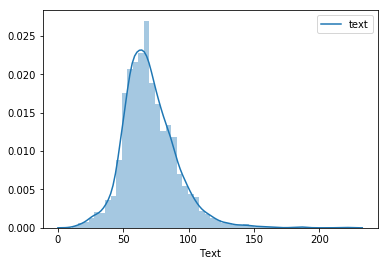

In [3]:
sns.distplot(train_df['Text'].map(lambda ele: len(ele.split(" "))), kde_kws={"label": "text"})

Set max length to 150 covers most of cases. Clip text where the token length longer than 150.

In [4]:
MAX_LEN = 150

In [5]:
def bs(list_, target_):
    lo, hi = 0, len(list_) -1
    
    while lo < hi:
        mid = lo + int((hi - lo) / 2)
        
        if target_ < list_[mid]:
            hi = mid
        elif target_ > list_[mid]:
            lo = mid + 1
        else:
            return mid + 1
    return lo

In [6]:
def clip_text(text, max_len, char_offset_p, char_offset_a, char_offset_b):
    doc = nlp(text)
    
    if len(doc) <= max_len:
        return text, 0
    
    token_lens = [token.idx for token in doc]
    char_offset_min = min(char_offset_p, char_offset_a, char_offset_b)
    char_offset_max = max(char_offset_p, char_offset_a, char_offset_b)
    
    # char offset to token offset
    mention_offset_min = bs(token_lens, char_offset_min) - 1
    mention_offset_max = bs(token_lens, char_offset_max) - 1
    
    if mention_offset_max - mention_offset_min + 1 > max_len:
        raise ValueError
    
    # make sure the mention is in the sentence span
    if mention_offset_max < max_len-1:
        hi = doc[max_len].idx
        return text[0:hi].strip(), 0
    else:
        len_span = mention_offset_max - mention_offset_min + 1
        hi_idx = min(int((max_len - len_span) / 2 + mention_offset_max + 1), len(doc))
        lo_idx = hi_idx - max_len
        text_append = text + " "
        return text_append[doc[lo_idx].idx: doc[hi_idx-1].idx + (doc[hi_idx-1].idx + len(doc[hi_idx-1]))].strip(), doc[lo_idx].idx
    
def text_clip_func(row, max_len):
    text, shift = clip_text(row['Text'], max_len, row['Pronoun-offset'], row['A-offset'], row['B-offset'])
    return pd.Series([text, shift], index=['Text', 'Shift'])

def text_clip_update(df, max_len):
    clip_info = df.apply(lambda row: text_clip_func(row, MAX_LEN), axis=1)
    df['Text'] = clip_info['Text']
    df['Pronoun-offset'] = df['Pronoun-offset'] - clip_info['Shift']
    df['A-offset'] = df['A-offset'] - clip_info['Shift']
    df['B-offset'] = df['B-offset'] - clip_info['Shift']

# Encode By BERT

Downloading the pre-trained BERT -Base, Uncased model. The kernel needs an Internet connection to do this, so make sure it's enabled.

In [7]:
#downloading weights and cofiguration file for the model
!wget https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-24_H-1024_A-16.zip
with zipfile.ZipFile("uncased_L-24_H-1024_A-16.zip","r") as zip_ref:
    zip_ref.extractall()
!ls 'uncased_L-24_H-1024_A-16'
os.system("rm " + "uncased_L-24_H-1024_A-16.zip")

--2019-04-08 02:41:06--  https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-24_H-1024_A-16.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 2607:f8b0:400e:c08::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1247797031 (1.2G) [application/zip]
Saving to: ‘uncased_L-24_H-1024_A-16.zip’

uncased_L-24_H-1024 100%[===================>]   1.16G  60.6MB/s    in 18s     

2019-04-08 02:41:24 (67.3 MB/s) - ‘uncased_L-24_H-1024_A-16.zip’ saved [1247797031/1247797031]

bert_config.json		     bert_model.ckpt.index  vocab.txt
bert_model.ckpt.data-00000-of-00001  bert_model.ckpt.meta


0

Next, in order to feed our data to the model, we'll use some scripts from the bert repo on GitHub.

In [8]:
!wget https://raw.githubusercontent.com/google-research/bert/master/modeling.py 
!wget https://raw.githubusercontent.com/google-research/bert/master/extract_features.py 
!wget https://raw.githubusercontent.com/google-research/bert/master/tokenization.py

--2019-04-08 02:41:45--  https://raw.githubusercontent.com/google-research/bert/master/modeling.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 37922 (37K) [text/plain]
Saving to: ‘modeling.py’

modeling.py         100%[===================>]  37.03K  --.-KB/s    in 0.007s  

2019-04-08 02:41:45 (4.95 MB/s) - ‘modeling.py’ saved [37922/37922]

--2019-04-08 02:41:46--  https://raw.githubusercontent.com/google-research/bert/master/extract_features.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13898 (14K) [text/plain]
Saving to: ‘extrac

In [9]:
import modeling
import extract_features
import tokenization
import tensorflow as tf

Next, we feed BERT the data from these three files. For each line, we want to obtain contextual embeddings for the 3 target words (A, B, Pronoun). Here are some helper functions to keep track of the offsets of the target words.

In [10]:
def compute_offset_no_spaces(text, offset):
    text_ = text[:offset]
    text_ = text_.replace(" ", "")
    return len(text_)

def count_length_no_special(text):
    special_char_list = ["#", " "]
    text_ = str(text)
    for char_ in special_char_list:
        text_ = text_.replace(char_, "")
    return len(text_)

The following method takes the data from a file, passes it through BERT to obtain contextual embeddings for the target words, then returns these embeddings in the emb DataFrame. Below, we will use it 3 times, once for each of the files gap-test, gap-development, gap-validation.

In [11]:
NUM_BERT_LAYERS = 6

In [12]:
def batch_file_path(dst_folder, dataset_name, batch_index, file_format):
    return dst_folder + "/" + dataset_name + '_' + str(batch_index) + file_format

In [13]:
def encode_by_bert_batch(data, embed_file_name, dst_folder, dataset_name, batch_index):
    '''
    Runs a forward propagation of BERT on input text, extracting contextual word embeddings
    Input: data, a pandas DataFrame containing the information in one of the GAP files

    Output: emb, a pandas DataFrame containing contextual embeddings for the words A, B and Pronoun. Each embedding is a numpy array of shape (768)
    columns: "emb_A": the embedding for word A
             "emb_B": the embedding for word B
             "emb_P": the embedding for the pronoun
             "label": the answer to the coreference problem: "A", "B" or "NEITHER"
    '''
    # From the current file, take the text only, and write it in a file which will be passed to BERT
    data["Text"].to_csv("input.txt", index=False, header=False)
    # The script extract_features.py runs forward propagation through BERT, and writes the output in the file output.jsonl
    # I'm lazy, so I'm only saving the output of the last layer. Feel free to change --layers = -1 to save the output of other layers.
    os.system("python3 extract_features.py \
      --input_file=input.txt \
      --output_file=" + embed_file_name + " \
      --vocab_file=uncased_L-24_H-1024_A-16/vocab.txt \
      --bert_config_file=uncased_L-24_H-1024_A-16/bert_config.json \
      --init_checkpoint=uncased_L-24_H-1024_A-16/bert_model.ckpt \
      --layers=-13,-14,-15,-16,-17,-18\
      --max_seq_length=" + str(int(MAX_LEN*1.6)) + " \
      --batch_size=8")
    os.system("rm input.txt")
    
    print(batch_index)
    bert_output = pd.read_json(embed_file_name, lines=True)

    index = data.index
    columns = ["emb_A", "emb_B", "emb_P", "label"]

    rdata = np.zeros(shape=(len(data), 3))
    # save embedding file
    batch_matrix = list()
    for i in range(len(data)):  # For each line in the data file

        # For each word, find the offset not counting spaces. This is necessary for comparison with the output of BERT
        P_offset = compute_offset_no_spaces(data.iloc[i]["Text"], data.iloc[i]["Pronoun-offset"])
        A_offset = compute_offset_no_spaces(data.iloc[i]["Text"], data.iloc[i]["A-offset"])
        B_offset = compute_offset_no_spaces(data.iloc[i]["Text"], data.iloc[i]["B-offset"])

        # Initialize counts
        count_chars = 0

        # find token index for P A and B
        features = bert_output.iloc[i]["features"]  # Get the BERT embeddings for the current line in the data file
        times_to_try = 7
        p_embds, a_embds, b_embds = None, None, None
        
        for j in range(2 if features[1]["token"] == "\"" else 1, len(features)):  # Iterate over the BERT  tokens for the current line; we skip over the first 2 tokens, which don't correspond to words
            token = features[j]["token"]

            # See if the character count until the current token matches the offset of any of the 3 target words
            if count_chars >= P_offset and p_embds is None:
                found = False
                for tt in range(times_to_try):
                    if features[max(0, j - tt)]["token"].lower().strip() == data.iloc[i]['Pronoun'].lower().strip():
                        rdata[i, 0] = max(0, j - tt)
                        found = True
                        break
                if not found:
                    for tt in range(times_to_try - 1):
                        if features[min(len(features) - 1, j + tt + 1)]["token"].lower().strip() == data.iloc[i]['Pronoun'].lower().strip():
                            rdata[i, 0] = min(len(features) - 1, j + tt + 1)
                            found = True
                            break
                if not found:
                    print("TOKEN NOT FOUND!")
                    print(features[max(0, j - times_to_try): min(len(features) - 1, j + times_to_try)]["token"])
                    print(data.iloc[i]['Pronoun'])
                    print(data.iloc[i]['Text'])
                    print()
                
                p_embds = [
                    layer_json['values']  for layer_json in features[int(rdata[i, 0])]["layers"]
                ]

            if count_chars >= A_offset and a_embds is None:
                found = False
                for tt in range(times_to_try):
                    if features[max(0, j - tt)]["token"].lower().strip() == data.iloc[i]['A'].lower().strip():
                        rdata[i, 1] = max(0, j - tt)
                        found = True
                        break
                if not found:
                    for tt in range(times_to_try - 1):
                        if features[min(len(features) - 1, j + tt + 1)]["token"].lower().strip() == data.iloc[i]['A'].lower().strip():
                            rdata[i, 1] = min(len(features) - 1, j + tt + 1)
                            found = True
                            break
                if not found:
                    print("TOKEN NOT FOUND!")
                    print(features[max(0, j - times_to_try):min(len(features) - 1, j + times_to_try)]["token"])
                    print(data.iloc[i]['A'])
                    print(data.iloc[i]['Text'])
                    print()
                    
                a_embds = [
                    layer_json['values']  for layer_json in features[int(rdata[i, 1])]["layers"]
                ]
                    
            if count_chars >= B_offset and b_embds is None:
                found = False
                for tt in range(times_to_try):
                    if features[max(0, j - tt)]["token"].lower().strip() == data.iloc[i]['B'].lower().strip():
                        rdata[i, 2] = max(0, j - tt)
                        found = True
                        break
                if not found:
                    for tt in range(times_to_try - 1):
                        if features[min(len(features) - 1, j + tt + 1)]["token"].lower().strip() == data.iloc[i]['B'].lower().strip():
                            rdata[i, 2] = min(len(features) - 1, j + tt + 1)
                            found = True
                            break
                if not found:
                    print("TOKEN NOT FOUND!")
                    print(features[max(0, j - times_to_try):min(len(features) - 1, j + times_to_try)]["token"])
                    print(data.iloc[i]['B'])
                    print(data.iloc[i]['Text'])
                    print()
                
                b_embds = [
                    layer_json['values']  for layer_json in features[int(rdata[i, 2])]["layers"]
                ]
            # Update the character count
            count_chars += count_length_no_special(token)
            
        if p_embds is None or a_embds is None or b_embds is None:
            print(count_chars)
            print(P_offset)
            print(A_offset)
            print(B_offset)
            print(data.iloc[i]["Text"])
            print([features[j]['token'] for j in range(2, len(features))])
            raise ValueError()
            
        batch_matrix.append([p_embds, a_embds, b_embds])
        p_embds, a_embds, b_embds = None, None, None
            
    batch_matrix = np.asarray(batch_matrix)
    np.save(batch_file_path(dst_folder, dataset_name, batch_index, ".npy"), batch_matrix)
        
    os.system("rm " + embed_file_name)

In [14]:
def encode_by_bert(data_df, batch_size, embed_file_name, dst_folder, dataset_name):
    num_batches = int(np.ceil(float(data_df.shape[0]) / batch_size))
    print('num batches:' + str(num_batches))
        
    for batch_index in range(num_batches):
        data_batch = data_df.iloc[batch_index * batch_size: min(batch_index * batch_size + batch_size, data_df.shape[0])]
        if data_batch.shape[0] == 0:
            break
        encode_by_bert_batch(data_batch, embed_file_name, dst_folder, dataset_name, batch_index)

# Process Data

In [15]:
! mkdir embs
embed_folder = "embs"

nlp = spacy.load('en_core_web_sm', disable=['tagger', 'ner', 'textcat'])

### Running Tests

In [16]:
# pd.options.display.max_colwidth = 1000

# dev_df = pd.read_csv(dev_df_path, sep='\t').drop(columns=['URL',])
# # clean text
# dev_df_ = dev_df.apply(entity_replace_func, axis=1)
# # clip text
# text_clip_update(dev_df_, MAX_LEN)

# for i in range(dev_df_.shape[0]):
#     row = dev_df_.iloc[i]
#     text = row['Text']
#     if text[row['A-offset']] != 'J':
#         print('J')
#         print(text)
#         print(text[row['A-offset']:row['A-offset']+10] )
#         print(dev_df.iloc[i][['Text', 'A', 'B']])
#     if text[row['B-offset']] != 'B':
#         print('B')
#         print(text)
#         print(text[row['B-offset']:row['B-offset']+10] )
#         print(dev_df.iloc[i][['Text', 'A', 'B']])


# encode
# dev_embed_file_name = "dev_embed.json"
# encode_by_bert(dev_df_, dev_embed_file_name)
# os.system("rm " + dev_embed_file_name)
# # split
# # split_embed_files(dev_embed_file_name, 32, embed_folder, "dev_embed")
# print("Finished at ", time.ctime())

In [17]:
print("Started at ", time.ctime())

train_embed_file_name = "train_embed.json"
dev_embed_file_name = "dev_embed.json"
test_embed_file_name = "test_embed.json"

batch_size = 180

# clip text
text_clip_update(train_df, MAX_LEN)
print("Finished at ", time.ctime())

# clip text
text_clip_update(dev_df, MAX_LEN)
print("Finished at ", time.ctime())

# clip text
text_clip_update(test_df, MAX_LEN)
print("Finished at ", time.ctime())

del nlp
gc.collect()

Started at  Mon Apr  8 02:41:49 2019


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-vers

Finished at  Mon Apr  8 02:42:19 2019
Finished at  Mon Apr  8 02:42:22 2019
Finished at  Mon Apr  8 02:42:39 2019


14

In [18]:
# encode
encode_by_bert(train_df, batch_size, train_embed_file_name, embed_folder, "train_embed")
encode_by_bert(dev_df, batch_size, dev_embed_file_name, embed_folder, "dev_embed")
encode_by_bert(test_df, batch_size, test_embed_file_name, embed_folder, "test_embed")
print("Finished at ", time.ctime())

num batches:23
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
num batches:3
0
1
2
num batches:12
0
1
2
3
4
5
6
7
8
9
10
11
Finished at  Mon Apr  8 04:29:06 2019


In [19]:
os.system("rm -rdf " + "uncased_L-24_H-1024_A-16")
os.system("rm " + "bert*")
os.system("rm " + "vocab.text")
os.system("rm " + "extract_features*")
os.system("rm " + "modeling*")
os.system("rm " + "tokenization*")
!ls

__notebook__.ipynb  __output__.json  __pycache__  embs
